# This is reVAMP

In [2]:
%matplotlib inline

import os
import time
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/sarah/reVAMP')
from src.model import profile_models
from src.dataset.spectrum import *
from src.dataset.preprocess import SplitRegions
from src.phase.evaluate import Process


In [3]:
# We need to set up and configure autofit
# We need to tell autofit where the config files are, and where to save the output information about the fits

import autofit as af

# Edit this to point to your own workspace directory
workspace_path = "/home/sarah/reVAMP/workspace/"
config_path = workspace_path + "config/"

af.conf.instance = af.conf.Config(
    config_path=config_path, output_path=workspace_path + "output"
)

In [4]:
# Load an example spectrum

data_dir = '/home/sarah/reVAMP/workspace/data/'
spectrum_file = data_dir + 'simba_H1215.h5'

dataset = read_from_h5py(spectrum_file)


In [5]:
# By default the flux array doesn't have noise, so we can add it on:

dataset.flux += dataset.noise

Computing detection regions...
Found 4 detection regions.


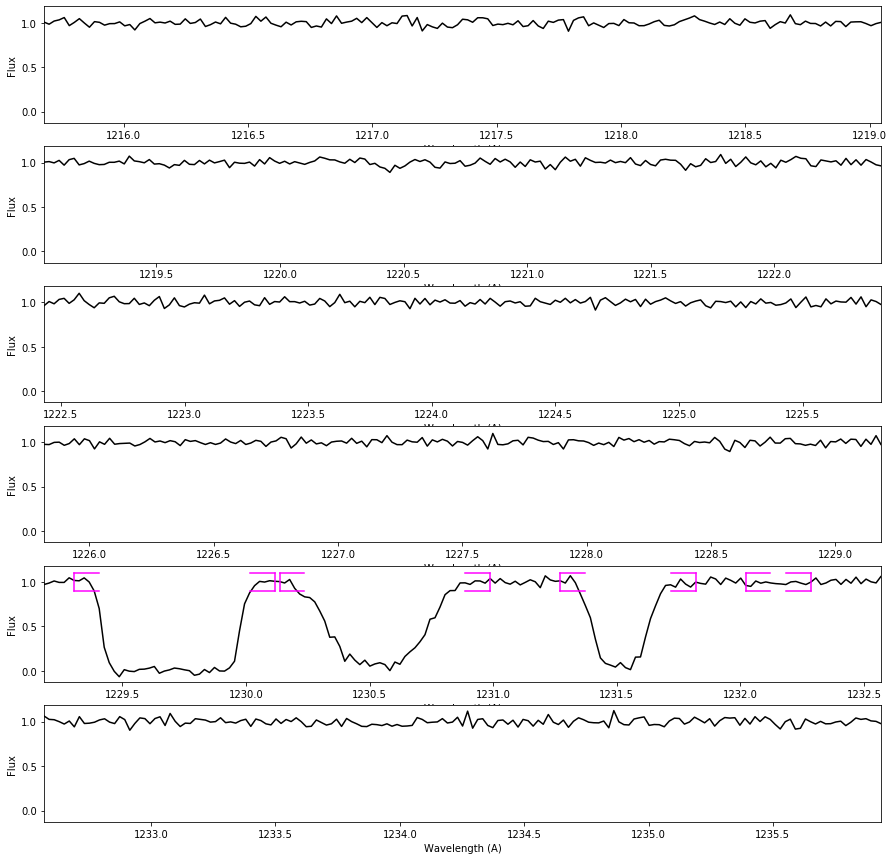

In [6]:
# Now we want to split the spectrum into manageable regions.
# This part is taken directly from the old VAMP, developed by Kate Storey-Fisher & Chris Lovell

split = SplitRegions(dataset)
split.plot_regions()

In [7]:
# Now we can just select one of our identified regions (let's choose the simplest one):

region = split.region_spectra[2]

In [8]:
# Now to fit the absorption feature. 
# As in the old VAMP, we can make an initial guess for the right number of profiles:

region.estimate_ncomp()
print(region.ncomp)

1


In [9]:
# We want to set some fitting variables:

reduced_chi_threshold = 2. # minimum chi squared for acceptable fit
ntries = 2. # number of times to attempt each number of components
non_linear_class = af.MultiNest # the fitting library to use. Other option: af.Emcee
phase_name = 'simba_H1215_' # name of this fit (for autofit bookkeeping)

There are various parameters we can change to vary the settings for the fit. These are contained in 'non_linear.ini' in the config directory; full documentation for these parameters is in 'doc_non_linear'.

MultiNest seems to be best for fits with few components, as it converges on the truth pretty quickly whereas MCMC will waste time exploring parameter space after the maximum likelihood has already been reached. However it may be worth exploring where to use MCMC, for example for saturated lines where MultiNest might fail, the MCMC might give us a semi-reasonable answer.

In [10]:
t_start = time.time()
vamp_process = Process(region, region.ncomp, non_linear_class, phase_name, reduced_chi_threshold, ntries)
print('\nTime taken: ' +str(time.time() - t_start))

Attempting 2 tries for each number of components


Time taken: 12.125017881393433


<Figure size 432x288 with 0 Axes>

Now if you check your workspace directory, there should be a new directory called 'output' (remember earlier we set the output directory for autofit). In the output directory, there will be a group of new directories that begin with the phase name we defined above. The naming convention for these directories is:

< phase_name > + '\_ncomp\_' + < number of profiles in the model > + '\_attempt\_' + < attempt number for the fit >

'Phase' is autofit terminology for a fit to a model. Each new directory contains the fit for a distinct phase.

Let's examine these. In each of these directories should be:
- 'image/'
    * Contains images of the fit which should continually update as multinest converges to a maximum likelihood.
- 'optimizer/'
    * Links to a directory in 'output' which has the information about the multinest fit. Autofit can use this to restart fits that are stopped, or skip fits that have already been done.
- 'optimizer_backup/'
    * Backup for optimizer.
- 'model.info'
    * Tells us what priors were used for each component of the model.
- 'model.results'
    * Tells us the results of the fit.
- 'output.log'
    *


In [11]:
# vamp_process contains information about each of the fits we tried:

print(vamp_process)

In [12]:
# We can take a look at how good each of the fits were:

print('Bayesian evidence: ' + str(vamp_process.evidence))
print('Reduced Chi squared: ' + str(vamp_process.reduced_chi))

Bayesian evidence: [39.654748683209675]
Reduced Chi squared: [1.6044089979359422]


In [13]:
# The most recent (hopefully best) phase has been saved:
print(vamp_process.result)

# We also have an 'output' attribute, which in this case is a MultiNestOutput object:
print('\n')
print(vamp_process.result.samples)

# This object acts as an interface between the MultiNest output results on your hard-disk and this Python code. For
# example, we can use it to get the evidence estimated by MultiNest.
print('\n')
print(vamp_process.result.samples.log_evidence)

Analysis Result:
samples: <autofit.optimize.non_linear.samples.NestedSamplerSamples object at 0x7f26acc15e50>
previous_model: <autofit.mapper.model_mapper.ModelMapper object at 0x7f26ac749390>
_Result__model: None
_instance: <autofit.mapper.model.ModelInstance object at 0x7f269ae07b10>
analysis: <src.phase.analysis.Analysis object at 0x7f26acd53f10>




39.654748683209675


In [14]:
# We can also use it to get a model-instance of the "most probable" model, which is the model where each parameter is
# the value estimated from the probability distribution of parameter space.
mp_instance = vamp_process.result.samples.most_probable_instance

print("Most Probable Model:\n")
print("Center = ", [i.center for i in mp_instance.profiles])
print("Intensity = ", [i.intensity for i in mp_instance.profiles])
print("Sigma = ", [i.sigma for i in mp_instance.profiles])

Most Probable Model:

Center =  [2419786468800913.0]
Intensity =  [4.13232035849654]
Sigma =  [118896481894.76758]


In [15]:
# We can get the fits for each of the components:
components = [p.absorption_line_from_frequencies(region.frequency) for p in mp_instance.profiles]

# And the overall model for the absorption feature:
model_spectrum = vamp_process.result.analysis.model_spectrum_from_instance(instance=mp_instance)

reduced_chi_squared = vamp_process.reduced_chi[-1]


Text(0.5, 1.0, 'reduced Chi squared: 1.60')

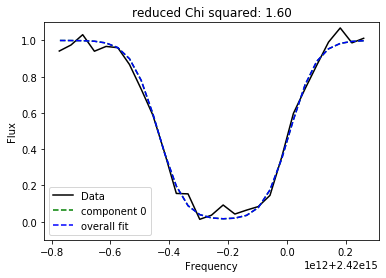

In [16]:
plt.plot(region.frequency, region.flux, c='k', label='Data')
for i, comp in enumerate(components):
    plt.plot(region.frequency, comp, c='g', ls='--', label='component %d' % i )
plt.plot(region.frequency, model_spectrum, c='b', ls='--', label='overall fit')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Flux')
plt.ylim(-0.1, 1.1)
plt.title('reduced Chi squared: %.2f' % round(reduced_chi_squared, 2))